In [1]:
%matplotlib inline
from matplotlib import style, figure
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

## Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")
conn = engine.connect()

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Exploratory Climate Analysis

### Precipitation Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

meas_columns = inspector.get_columns('measurement')
for column in meas_columns:
    print(column["name"], column["type"])

# Calculate the date 1 year ago from today
   ### data provided does not allow for this ###

# Perform a query to retrieve the data and precipitation scores

meas_query = engine.execute('SELECT date , prcp FROM measurement').fetchall()
# meas_query

# Save the query results as a Pandas DataFrame and set the index to the date column

   ### trying mask ###
measurement_df = pd.DataFrame(meas_query)
measurement_df = measurement_df.rename(columns={0: 'date', 1: 'prcp'})
measurement_df['date'] =  pd.to_datetime(measurement_df['date'], format='%Y-%m-%d')
measurement_df.head()
mask = (measurement_df['date'] > '2016-08-23') & (measurement_df['date'] <= '2017-08-23')
measurement_df_1year = measurement_df.loc[mask]
measurement_df_1year = measurement_df_1year.set_index(['date'])

# Sort the dataframe by date
measurement_df_1year.sort_index()
measurement_df_1year.head()
# measurement_df_1year.count()

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


,prcp
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


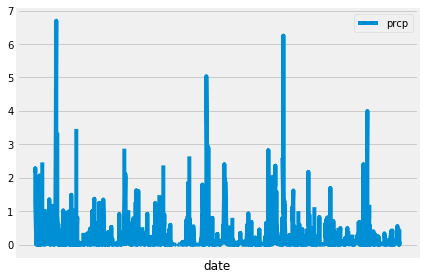

In [11]:
# Use Pandas Plotting with Matplotlib to plot the data

measurement_df_1year.plot()
plt.xticks([])
plt.tight_layout()
plt.show()

# Rotate the xticks for the dates

# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False) # labels along the bottom edge are off



In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data

   ### I assume you mean for the one year selected to analyze.
measurement_df_1year.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Climate Analysis

In [13]:
# How many stations are available in this dataset?

# stat_columns = inspector.get_columns('station')
# for column in stat_columns:
#     print(column["name"], column["type"])
    
stat_query = engine.execute('SELECT COUNT(station) FROM station').fetchall()
station_count = stat_query[0][0]

print(f'There are {station_count} stations in the dataset.')

There are 9 stations in the dataset.


In [14]:
# What are the most active stations?
# List the stations and the counts in descending order.
active_stations = [Measurement.station, 
       func.count(Measurement.station)]
activestations_query = session.query(*active_stations).\
    group_by(Measurement.station).\
    order_by(desc(func.count(Measurement.station))).all()
activestations_query

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

USC281_query = engine.execute('SELECT MIN(tobs), MAX(tobs), AVG(tobs) FROM measurement WHERE station = "USC00519281"').fetchall()
USC281_stats = USC281_query[0]
USC281_stats

(54.0, 85.0, 71.66378066378067)

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
USC281_plotquery = engine.execute('SELECT date , tobs FROM measurement WHERE station = "USC00519281" AND date > "2016-08-23"').fetchall()
USC281_plotquery

usc281_df = pd.DataFrame(USC281_plotquery)
usc281_df = usc281_df.rename(columns={0: 'date', 1: 'tobs'})
usc281_df.head()

,date,tobs
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0


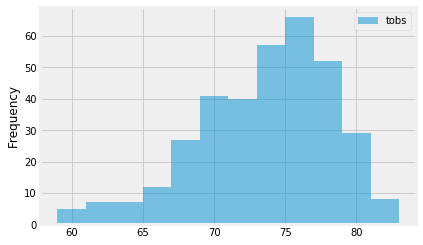

In [17]:
usc281_df.plot.hist(bins = 12, alpha=.5)
# plt.xticks([])
# plt.tight_layout()
# plt.show()

In [18]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

   ### Trip dates: 7/1/17 - 7/8/17
    
print(calc_temps('2016-07-01', '2016-07-08'))

[(71.0, 76.95833333333333, 82.0)]


([<matplotlib.axis.YTick at 0x1f42d618320>,
 <a list of 6 Text yticklabel objects>)

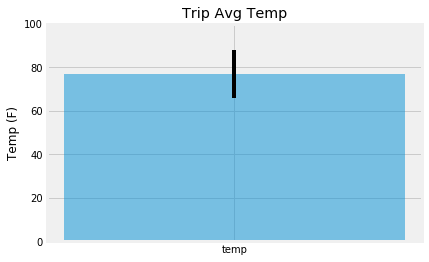

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

trip_stats = calc_temps('2016-07-01', '2016-07-08')

trip_yaxis = trip_stats[0][1]
trip_min = trip_stats[0][0]
trip_max = trip_stats[0][2]
error = [trip_max - trip_min]

plt.bar("temp", trip_yaxis, alpha=.5, align = "center", yerr = error, width=.01)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.yticks(np.arange(0, 110, 20))

In [21]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

prcptrip_query = engine.execute('SELECT measurement.station, name, latitude, longitude, elevation, AVG(prcp) FROM measurement \
LEFT JOIN station ON measurement.station = station.station \
WHERE date BETWEEN "2016-07-01" AND "2016-07-08" GROUP BY measurement.station ORDER BY AVG(prcp) DESC').fetchall()
prcptrip_query

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.785),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.185),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.095),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.088),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.07500000000000001),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.01125),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]

## Climate App Brainstorming

In [22]:
# # Flask App  ---  Pandas

# import os

# # Module for reading CSV files
# import csv

# csvpath = os.path.join('./hawaii_measurements.csv')

# datelist = []
# tobslist = []

# with open(csvpath, newline='') as csvfile:

#     # CSV reader specifies delimiter and variable that holds contents
#     csvreader = csv.reader(csvfile, delimiter=',')

#     print(csvreader)

#     # Read the header row first (skip this step if there is now header)
#     csv_header = next(csvreader)
# #     print(f"CSV Header: {csv_header}")

#     # Read each row of data after the header
#     for row in csvreader:
#         datelist.append(row[1])
#         tobslist.append(row[3])
        
# listdf = pd.DataFrame(list)
# dict = listdf.to_dict()

# tobslist

# full_df = pd.DataFrame(datelist, columns = {'date'})
# full_df.rename(columns = {0:'date'})
# full_df['tobs'] = tobslist
# full_df.set_index('date')  ### not working
# full_df.head()

# # full_df.to_dict()

# results = session.query(Measurement.date, Measurement.tobs).all()
# results

# all_tobs = []
# # for data in results:
# #     tobs_dict = {}
# #     tobs_dict["date"] = data.date 
# #     tobs_dict["tobs"] = data.tobs
# #     all_tobs.append(tobs_dict)

# for data in results:
#     tobs_dict = {}
#     tobs_dict[data.date] = data.tobs 
# #     tobs_dict["tobs"] = data.tobs
#     all_tobs.append(tobs_dict)

# #     return jsonify(all_tobs)

# all_tobs